In [37]:
import pandas as pd
base = pd.read_csv('../dataset/dataset_train.csv')
base = base.dropna()

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler_price = MinMaxScaler()
base[['sold_price']] = scaler_price.fit_transform(base[['sold_price']])

In [39]:
base

,negotiation_date,sold_price,product
0,07/01/2014,0.233329,Polpa Cítrica
1,08/01/2014,0.222386,Polpa Cítrica
2,09/01/2014,0.214286,Polpa Cítrica
3,10/01/2014,0.255714,Polpa Cítrica
4,11/01/2014,0.151014,Polpa Cítrica
...,...,...,...
1632,26/07/2019,0.255843,Polpa Cítrica
1633,27/07/2019,0.250000,Polpa Cítrica
1634,29/07/2019,0.228571,Polpa Cítrica
1635,30/07/2019,0.292857,Polpa Cítrica


In [40]:
base = base.iloc[:, 1].values

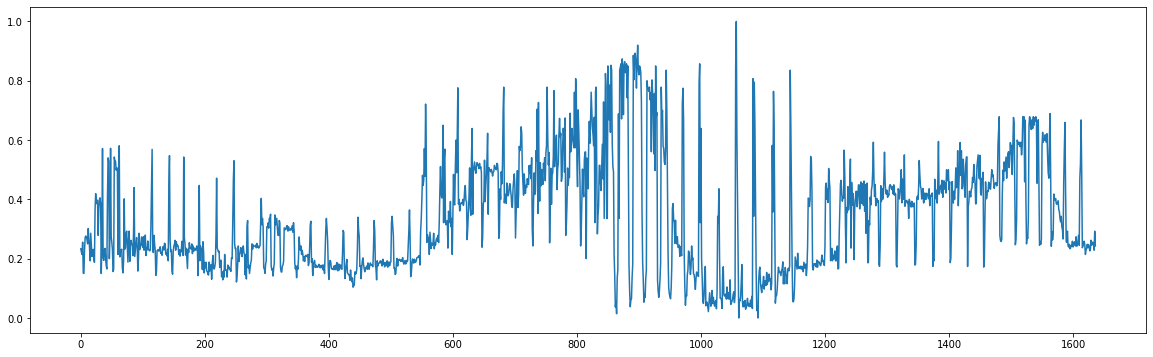

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.plot(base)
plt.show()

In [42]:
import numpy as np
def proximo_batch(treino):
    # Seleciona um número aleatório dentro dos índices da base
    inicio = np.random.randint(0,len(treino)-31)
    # Seleciona dentro do conjunto teste o X_test
    X_treino = treino[inicio: inicio + 30].reshape(1,30,1)
    # Seleciona dentro do conjunto teste o y_test
    y_treino = treino[inicio+1: inicio + 31].reshape(1,30,1)
    return X_treino, y_treino

X_teste = base[-31:-1].reshape(1,30,1)
y_teste = base[-30:].reshape(1,30,1)


In [43]:
def init_batches():
    X_batches = []
    y_batches = []
    for i in range(100):
        X_batch, y_batch = proximo_batch(base[:-31])
        X_batches.append(X_batch[0])
        y_batches.append(y_batch[0])
    X_batches = np.array(X_batches)
    y_batches = np.array(y_batches)
    return X_batches, y_batches

In [44]:
periodos = 30 # de quantos em quantos periodos sao os dados ()
previsao_futura = 1 # saber um periodo

X = base[0:(len(base) - (len(base) % periodos))]
X_batches = X.reshape(-1, periodos, 1)
y = base[1:(len(base) - (len(base) % periodos)) + previsao_futura]
y_batches = y.reshape(-1, periodos, 1)

X_teste = base[-(periodos + previsao_futura):]
X_teste = X_teste[:periodos]
X_teste = X_teste.reshape(-1, periodos, 1)
y_teste = base[-(periodos):]
y_teste = y_teste.reshape(-1, periodos, 1)

In [45]:
X_batches.shape, y_batches.shape, X_teste.shape, y_teste.shape

((54, 30, 1), (54, 30, 1), (1, 30, 1), (1, 30, 1))

In [46]:
import tensorflow as tf
tf.random.set_seed(42)

tf.__version__

'2.4.1'

In [76]:
entradas = 1
neuronios_oculta = 350
neuronios_saida = 1

# Usando RNN Simples

In [77]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.rnn = tf.keras.layers.LSTM(units = neuronios_oculta, activation = 'relu', return_sequences = True, kernel_initializer=tf.keras.initializers.GlorotNormal())
        self.dense = tf.keras.layers.Dense(units = neuronios_saida, kernel_initializer=tf.keras.initializers.GlorotNormal())
    
    def call(self, inputs):
        x = self.rnn(inputs)
        x = self.dense(x)

        return x

In [79]:
model = Model()
otimizador = tf.keras.optimizers.Adam(learning_rate = 0.001)

for epoca in range(1000):
    X_batches, y_batches = proximo_batch(base[:-31])
    with tf.GradientTape() as tape:
        out = model(X_batches)
        erro = tf.keras.losses.mean_squared_error(out, y_batches)
    
    gradientes = tape.gradient(erro, model.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

    if epoca % 100 == 0:
        print(epoca + 1, ' erro: ', tf.reduce_mean(erro).numpy())

1  erro:  0.06867725524977294
101  erro:  0.008990832281583734
201  erro:  0.02504805053470075
301  erro:  0.006181918666357157
401  erro:  0.039695720639949396
501  erro:  0.015704693301357944
601  erro:  0.03645149248478642
701  erro:  0.03196271123787202
801  erro:  0.004111318118608592
901  erro:  0.005794256383329963


In [80]:
previsoes = model(X_teste)
previsoes = scaler_price.inverse_transform(previsoes[0])

In [81]:
previsoes

array([[345.70611238],
       [351.02094531],
       [346.88414752],
       [352.95976222],
       [336.32722616],
       [449.20216024],
       [484.18700218],
       [561.61471725],
       [481.8498534 ],
       [347.56605148],
       [327.83915222],
       [337.62652993],
       [342.50447869],
       [337.00806618],
       [319.82972741],
       [324.51028347],
       [327.24027753],
       [333.26874495],
       [327.16715753],
       [330.23252308],
       [326.20028377],
       [317.81231433],
       [318.31670672],
       [333.3398205 ],
       [326.39031231],
       [327.82667696],
       [329.22098458],
       [326.09889627],
       [314.88309175],
       [344.64269102]])

In [82]:
import numpy as np
y_teste2 = np.ravel(scaler_price.inverse_transform(y_teste[0]))

In [83]:
y_teste2

array([316.88, 325.  , 340.  , 316.67, 475.  , 508.5 , 612.5 , 490.  ,
       310.94, 314.  , 325.  , 326.25, 317.31, 295.  , 305.83, 309.44,
       318.95, 310.94, 318.33, 313.24, 303.33, 306.67, 328.57, 316.67,
       321.67, 324.09, 320.  , 305.  , 350.  , 315.  ])

In [84]:
previsoes2 = np.ravel(previsoes)

In [85]:
previsoes2

array([345.70611238, 351.02094531, 346.88414752, 352.95976222,
       336.32722616, 449.20216024, 484.18700218, 561.61471725,
       481.8498534 , 347.56605148, 327.83915222, 337.62652993,
       342.50447869, 337.00806618, 319.82972741, 324.51028347,
       327.24027753, 333.26874495, 327.16715753, 330.23252308,
       326.20028377, 317.81231433, 318.31670672, 333.3398205 ,
       326.39031231, 327.82667696, 329.22098458, 326.09889627,
       314.88309175, 344.64269102])

In [86]:
print(np.sqrt(
        np.square(
            np.subtract(y_teste2, previsoes2)).mean()))

53.27638758446397


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_teste2, previsoes2)
mae

In [ ]:
plt.plot(y_teste2, '*', markersize = 10, label = 'Valor real')
plt.plot(previsoes2, 'o', label = 'Previsões')
plt.legend()

In [ ]:
plt.plot(y_teste2, label = 'Valor real')
plt.plot(y_teste2, 'w*', markersize = 10, color = 'red')
plt.plot(previsoes2, label = 'Previsões')
plt.legend()

# Usando LSTM

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.lstm = tf.keras.layers.LSTM(units = neuronios_oculta, activation = 'relu', return_sequences = True)
        self.dense = tf.keras.layers.Dense(units = neuronios_saida)
    
    def call(self, inputs):
        x = self.lstm(inputs)
        x = self.dense(x)

        return x

In [ ]:
model = Model()
otimizador = tf.keras.optimizers.Adam(learning_rate = 0.001)

for epoca in range(1000):
    with tf.GradientTape() as tape:
        out = model(X_batches)
        erro = tf.keras.losses.mean_squared_error(out, y_batches)
    
    gradientes = tape.gradient(erro, model.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

    if epoca % 100 == 0:
        print(epoca + 1, ' erro: ', tf.reduce_mean(erro).numpy())

In [ ]:
previsoes = model(X_teste)
previsoes = scaler_price.inverse_transform(previsoes[0])
previsoes

In [ ]:
y_teste2

In [ ]:
print(np.sqrt(
        np.square(
            np.subtract(y_teste2, previsoes2)).mean()))

# Múltiplas camadas LSTM

O construtor para empilhar células com estrutura de RNN deve ser `tf.keras.layers.StackedRNNCells`, que depois deve ser consolidada em uma camada usando o construtor `tf.keras.layers.RNN`, conforme exemplo em https://www.tensorflow.org/api_docs/python/tf/keras/layers/StackedRNNCells#examples

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        lstms = [tf.keras.layers.LSTMCell(units = neuronios_oculta, activation = 'relu') for _ in range(4)]
        stacked_lstm = tf.keras.layers.StackedRNNCells(cells = lstms)
        self.lstm_layer = tf.keras.layers.RNN(cell = stacked_lstm, return_sequences = True)
        self.dense = tf.keras.layers.Dense(units = neuronios_saida)
    
    def call(self, inputs):
        x = self.lstm_layer(inputs)
        x = self.dense(x)

        return x

In [ ]:
model = Model()
otimizador = tf.keras.optimizers.Adam(learning_rate = 0.001)

for epoca in range(1000):
    with tf.GradientTape() as tape:
        out = model(X_batches)
        erro = tf.keras.losses.mean_squared_error(out, y_batches)
    
    gradientes = tape.gradient(erro, model.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

    if epoca % 100 == 0:
        print(epoca + 1, ' erro: ', tf.reduce_mean(erro).numpy())

In [ ]:
previsoes = model(X_teste)
previsoes

In [ ]:
plt.plot(y_teste2, label = 'Valor real')
plt.plot(y_teste2, 'w*', markersize = 10, color = 'red')
plt.plot(previsoes2, label = 'Previsões')
plt.legend()

In [ ]:
y_teste2 = np.ravel(y_teste)
previsoes2 = np.ravel(previsoes.numpy())
mae = mean_absolute_error(y_teste2, previsoes2)
mae

In [ ]:
print(np.sqrt(
        np.square(
            np.subtract(y_teste2, previsoes2)).mean()))